In [ ]:
#!pip install -q tensorflow==2.14.0 matplotlib scikit-learn seaborn kaggle

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.14.0


### Getting Data

In [ ]:
# get the token https://www.kaggle.com/settings
import os
os.environ['KAGGLE_USERNAME'] = '<YOUR_KAGGLE_USERNAME>'
os.environ['KAGGLE_KEY'] = '<YOUR_KAGGLE_KEY>'

In [ ]:
# https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

 99% 383M/385M [00:20<00:00, 23.1MB/s]
100% 385M/385M [00:20<00:00, 19.3MB/s]


In [ ]:
!ls

cards-image-datasetclassification.zip  sample_data


In [ ]:
import os
import zipfile

local_zip = 'cards-image-datasetclassification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cards')
zip_ref.close()

In [ ]:
ls /tmp/cards

'14card types-14-(200 X 200)-94.61.h5'   cards.csv   train/
'53cards-53-(200 X 200)-100.00.h5'       test/       valid/


In [ ]:
ls /tmp/cards/train

'ace of clubs'/       'four of hearts'/    'nine of spades'/     'ten of diamonds'/
'ace of diamonds'/    'four of spades'/    'queen of clubs'/     'ten of hearts'/
'ace of hearts'/      'jack of clubs'/     'queen of diamonds'/  'ten of spades'/
'ace of spades'/      'jack of diamonds'/  'queen of hearts'/    'three of clubs'/
'eight of clubs'/     'jack of hearts'/    'queen of spades'/    'three of diamonds'/
'eight of diamonds'/  'jack of spades'/    'seven of clubs'/     'three of hearts'/
'eight of hearts'/     joker/              'seven of diamonds'/  'three of spades'/
'eight of spades'/    'king of clubs'/     'seven of hearts'/    'two of clubs'/
'five of clubs'/      'king of diamonds'/  'seven of spades'/    'two of diamonds'/
'five of diamonds'/   'king of hearts'/    'six of clubs'/       'two of hearts'/
'five of hearts'/     'king of spades'/    'six of diamonds'/    'two of spades'/
'five of spades'/     'nine of clubs'/     'six of hearts'/
'four of clubs'/      'nin

In [ ]:
base_dir = '/tmp/cards'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

### Processing Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  label_mode='int',
  batch_size=BATCH_SIZE)

# validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  seed=123,
  label_mode='int',
  batch_size=BATCH_SIZE)

# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='int',
  shuffle=False,
  batch_size=BATCH_SIZE)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [ ]:
# class names
class_names = train_ds.class_names
class_names

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

In [ ]:
# define augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomWidth(0.1),
  tf.keras.layers.RandomHeight(0.1),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(0.1)
])

# Apply data_augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

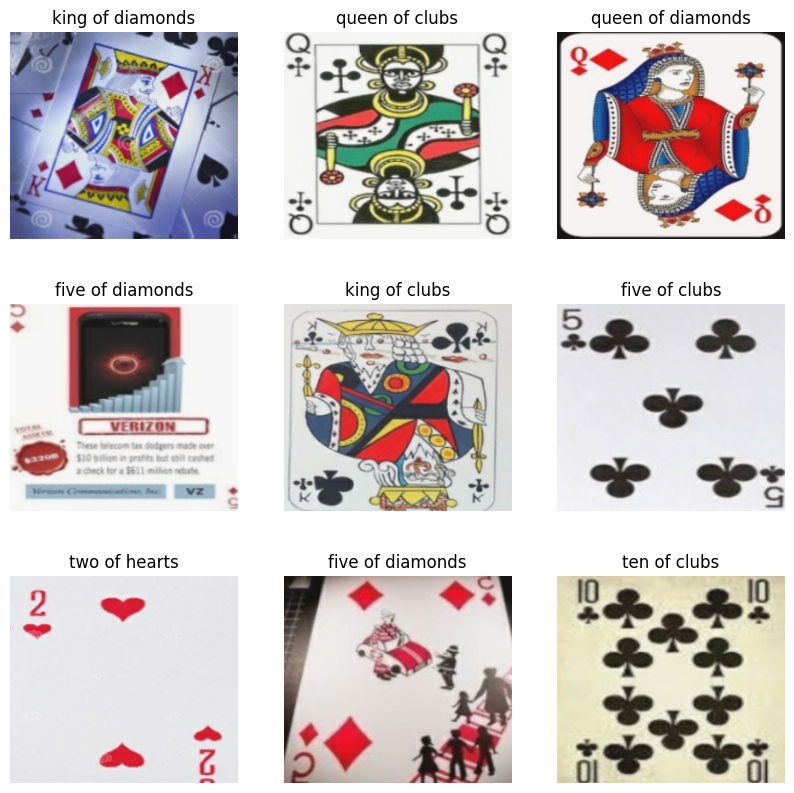

In [ ]:
image_batch, label_batch = next(iter(train_ds))

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Buidlling Deep Learning Model

In [ ]:
# reset the session
tf.keras.backend.clear_session()

In [ ]:
# define model
model = tf.keras.models.Sequential([
                                     tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                     tf.keras.layers.Rescaling(1./255),
                                     tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                     tf.keras.layers.Dropout(0.20),
                                     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                     tf.keras.layers.Dropout(0.20),
                                     tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                     tf.keras.layers.Dropout(0.20),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(128, activation='relu'),
                                     tf.keras.layers.Dropout(0.20),
                                     tf.keras.layers.Dense(53, activation='softmax')])


In [ ]:
# compile model
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# summary
model.build(input_shape=(None,IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                        

### Training Model

In [ ]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           mode='auto')

In [ ]:
# training model
import time
start_time = time.time()
history = model.fit(train_ds,
                    epochs = 30,
                    validation_data=validation_ds,
                    callbacks=[early_stopping_callback])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30
239/239 [==============================] - 120s 250ms/step - loss: 3.8034 - accuracy: 0.0679 - val_loss: 2.8722 - val_accuracy: 0.1811
Epoch 2/30
239/239 [==============================] - 62s 256ms/step - loss: 2.7826 - accuracy: 0.2276 - val_loss: 1.9198 - val_accuracy: 0.4151
Epoch 3/30
239/239 [==============================] - 61s 255ms/step - loss: 2.3402 - accuracy: 0.3392 - val_loss: 1.5861 - val_accuracy: 0.5283
Epoch 4/30
239/239 [==============================] - 61s 253ms/step - loss: 2.1010 - accuracy: 0.4041 - val_loss: 1.3202 - val_accuracy: 0.6113
Epoch 5/30
239/239 [==============================] - 61s 252ms/step - loss: 1.9053 - accuracy: 0.4586 - val_loss: 1.1464 - val_accuracy: 0.6679
Epoch 6/30
239/239 [==============================] - 61s 252ms/step - loss: 1.7224 - accuracy: 0.5067 - val_loss: 1.0666 - val_accuracy: 0.6981
Epoch 7/30
239/239 [==============================] - 61s 252ms/step - loss: 1.5862 - accuracy: 0.5460 - val_loss: 1.0053 - val_a

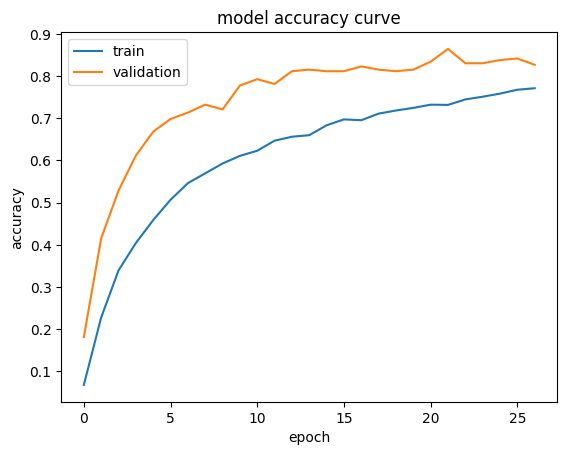

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

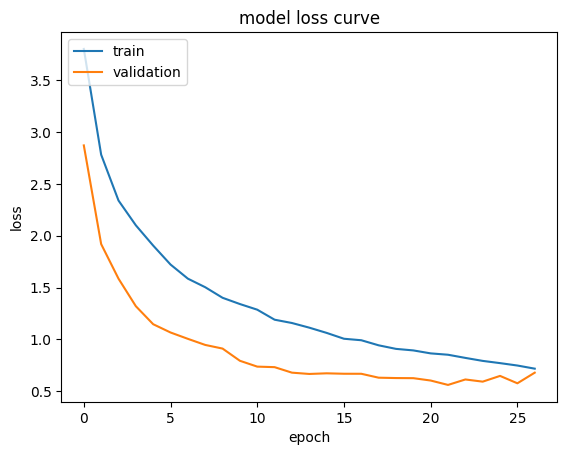

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate Model

In [ ]:
# evaluate model
model.evaluate(test_ds)

9/9 [==============================] - 0s 37ms/step - loss: 0.7266 - accuracy: 0.8340


[0.7265996932983398, 0.8339622616767883]

In [ ]:
# generate predictions
y_pred = model.predict(test_ds)
predicted_categories = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)
# actual categories
true_categories = tf.cast(tf.concat([label for img, label in test_ds], axis=0), tf.int32)

9/9 [==============================] - 0s 34ms/step


In [ ]:
# calculate accuracy
equality = tf.math.equal(predicted_categories, true_categories)
accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.83396226>

In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(true_categories,predicted_categories))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           6       1.00      0.80      0.89         5
           7       0.80      0.80      0.80         5
           8       1.00      0.60      0.75         5
           9       0.75      0.60      0.67         5
          10       1.00      0.80      0.89         5
          11       1.00      0.80      0.89         5
          12       1.00      0.60      0.75         5
          13       0.83      1.00      0.91         5
          14       0.71      1.00      0.83         5
          15       1.00      0.60      0.75         5
          16       0.80      0.80      0.80         5
          17       1.00    

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# create confusion matrix
cm = confusion_matrix(predicted_categories, true_categories)

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

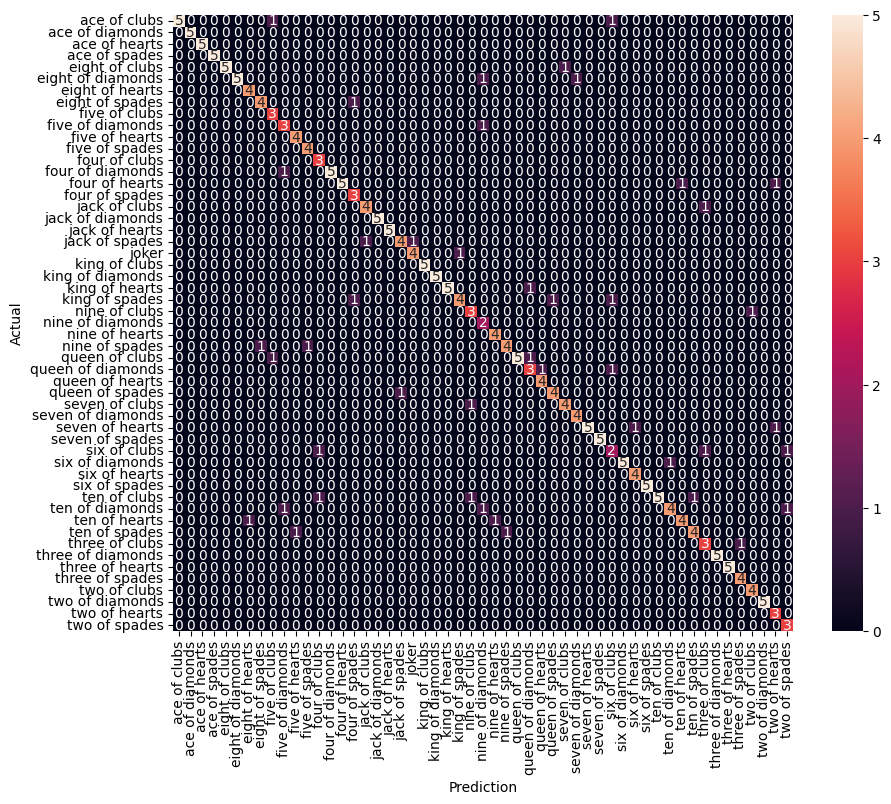

In [ ]:
# plot confusion matrix
show_confusion_matrix(cm, class_names)

### Evaluate Model on Sample Images

In [ ]:
# king of hearts
!wget --no-check-certificate \
  https://m.media-amazon.com/images/I/71d4LRYo6uL._AC_UF1000,1000_QL80_.jpg \
  -O /tmp/king_of_hearts.jpg


# ace of clubs
!wget --no-check-certificate \
  https://upload.wikimedia.org/wikipedia/commons/2/2a/Ace_of_clubs.png \
  -O /tmp/ace_of_clubs.png

--2023-11-15 13:47:28--  https://m.media-amazon.com/images/I/71d4LRYo6uL._AC_UF1000,1000_QL80_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 18.155.63.177, 2600:9000:23d2:800:1d:d7f6:39d3:7a61, 2600:9000:23d2:3200:1d:d7f6:39d3:7a61, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|18.155.63.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112774 (110K) [image/jpeg]
Saving to: ‘/tmp/king_of_hearts.jpg’

/tmp/king_of_hearts 100%[===================>] 110.13K  --.-KB/s    in 0.004s  

2023-11-15 13:47:28 (24.2 MB/s) - ‘/tmp/king_of_hearts.jpg’ saved [112774/112774]

--2023-11-15 13:47:28--  https://upload.wikimedia.org/wikipedia/commons/2/2a/Ace_of_clubs.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20976 (20K) [image/png]
Saving to: ‘/tmp/

In [ ]:
import numpy as np
def classify(image_path):
  # load image
  image = tf.keras.utils.load_img(image_path, color_mode='rgb')
  # display the image
  display(image)
  # conver image to array
  input_arr = tf.keras.utils.img_to_array(image)
  # convert single image to a batch
  input_arr = np.array([input_arr])
  print(f'Input array shape: {input_arr.shape}')
  # get predicted probabilities
  y_pred = model.predict(input_arr)
  # get predicted category
  predicted_category = tf.argmax(y_pred, axis=1)
  # get predicted category class name
  predicted_category_classname = class_names[int(predicted_category)]
  print(f'Predicted class: {predicted_category_classname}')

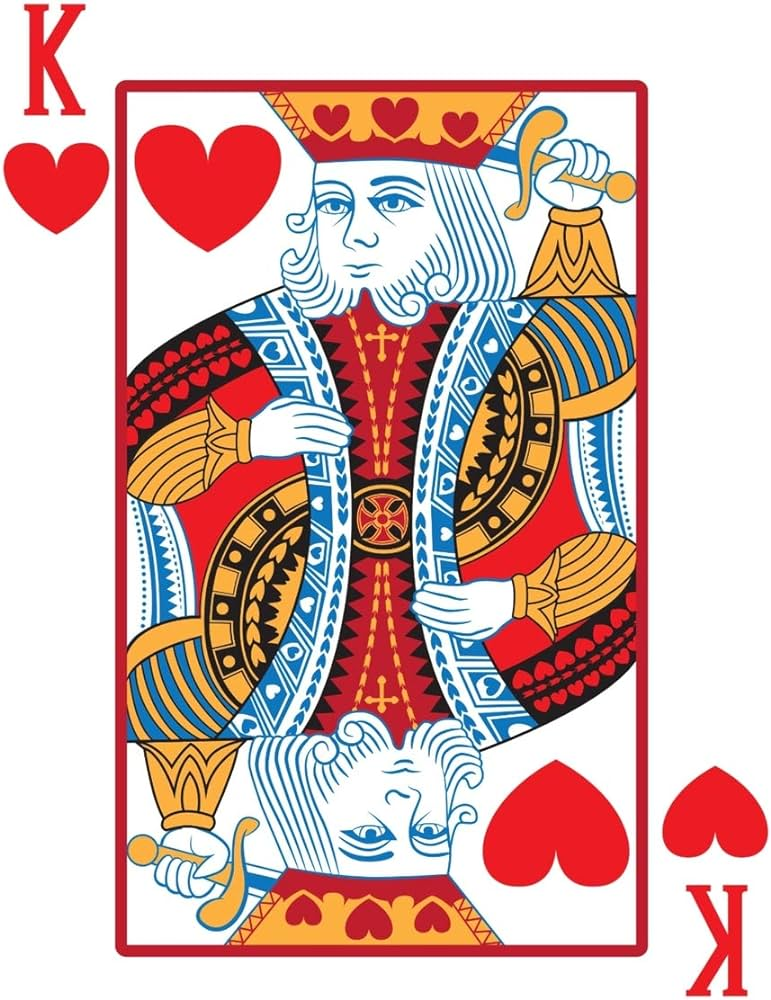

Input array shape: (1, 1000, 771, 3)
1/1 [==============================] - 0s 303ms/step
Predicted class: king of hearts


In [ ]:
# test 1
classify('/tmp/king_of_hearts.jpg')

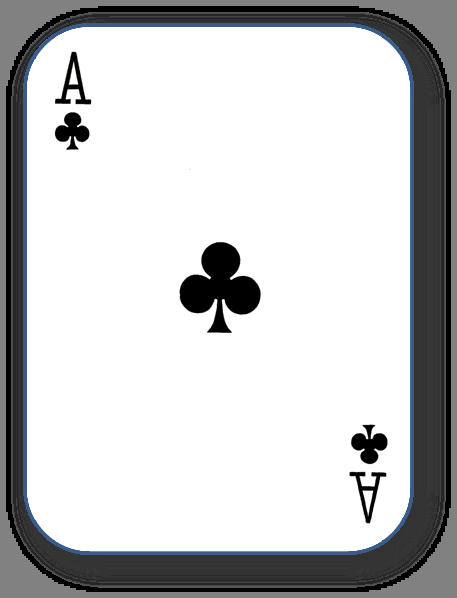

Input array shape: (1, 598, 457, 3)
1/1 [==============================] - 0s 85ms/step
Predicted class: ace of clubs


In [ ]:
#test 2
classify('/tmp/ace_of_clubs.png')